In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.2.0


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("슝=3")

슝=3


### 포지셔널 인코딩
* 임베딩까지 한번에 처리
* 인코딩은 단순 구분을 위한 수치화, 임베딩은 단어에 의미를 부여

* 입력 데이터 → [ batch_size x length ]
* Source & Target Embedding → [ batch_size x length x d_emb ]
* Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.
* Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.
* Split Heads → [ batch_size x length x heads x (d_emb / n_heads) ]
* Masking for Masked Attention
* Scaled Dot Product Attention
* Combine Heads →[ batch_size x length x d_emb ]
* esidual Connection
* Layer Normalization
* Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]
* Output Linear Layer → [ batch_size x length x vocab_size ]

In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        # tf.matmul을 사용하는 이유는 입력값으로 다양한 tenser와 None이 들어왔을때를 위해
        # tf.math.sqrt를 사용하는 이유는 다양한 tenser를 받기 위해
        scaled_qk = tf.matmul(Q, K, transpose_b = True) / tf.math.sqrt(d_k)
        

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        #axis는 디폴트로 -1, 마지막 차원을 명시해주는것
        attestions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        def split_heads(self, x):
            bsz = x.shape[0]# 일반적으로 입력텐서는 (batch_size, max_len, embedding_dim으로 구성)
            split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))# reshape(tensor, 변환형태), -1은 구조를 맞춰줌
            split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])# perm: 입력 텐서의 인덱스를 기준으로 변환

        return split_x


    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """

        return out, attention_weights

print("슝=3")

슝=3


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)# [1, 100, 300]
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [5]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    check_point = {}
    kor_cleaned_corpus = []
    eng_cleaned_corpus = []

    for k, e in zip(kor, eng):
        if k not in check_point:
            check_point[k] = 1
            kor_cleaned_corpus.append(k)
            eng_cleaned_corpus.append(e)

            
    return kor_cleaned_corpus, eng_cleaned_corpus

k_corpus, e_corpus = clean_corpus(kor_path, eng_path)
print(k_corpus[:5], e_corpus[:5])

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.', '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.', '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.'] ['Much of personal computing is about "can you top this?"', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.', "Like all optical mice, But it also doesn't need a desk.", 'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.', "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack."]


In [6]:
len(k_corpus)

77591

2) 정제 함수를 아래 조건을 만족하게 정의하세요.

조건

* 모든 입력을 소문자로 변환합니다.
* 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
* 문장부호 양옆에 공백을 추가합니다.
* 문장 앞뒤의 불필요한 공백을 제거합니다.

In [7]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([!,.?])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z!,.?]+", " ", sentence)
    sentence = sentence.strip()
        
    return sentence

In [8]:
preprocess_sentence("AAA에이에이에이에이 오늘도 힘들다 1 2  3 ! @   #", s_token = True, e_token = True)

'aaa에이에이에이에이 오늘도 힘들다 !'

3) 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

조건

* 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
* 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
* 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
  * <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

In [9]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                       vocab_size,
                       lang,
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write('{}\n'.format(row))

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer
    
kor_corpus = []
eng_corpus = []

for k, e in zip(k_corpus, e_corpus):
    
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e, s_token = True, e_token = True))
    
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 10000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [10]:
print(len(kor_corpus))
print(kor_corpus[:5], eng_corpus[:5])

77591
['개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다 .', '그러나 이것은 또한 책상도 필요로 하지 않는다 .', '. 달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다 .', '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을 밝혔으며 , 세계 해상 교역량의 거의 분의 을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다 .'] ['much of personal computing is about can you top this ?', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable , wireless mouse .', 'like all optical mice , but it also doesn t need a desk .', 'uses gyroscopic sensors to control the cursor movement as you move your wrist , arm , whatever through the air .', 'intelligence officials have revealed a spate of foiled plots on ships in southeast asia and are warning that a narrow stretch of water carrying almost one third of the world s maritime trade is vulnerable to a terror attack .']


In [11]:
print(kor_corpus[2])

그러나 이것은 또한 책상도 필요로 하지 않는다 .


### 텍스트를 토큰화하는 2가지 방법

In [12]:
range(5)

range(0, 5)

In [52]:
# 단어단위로 토큰화
ko_tokenizer.piece_to_id(kor_corpus[2])

3

In [53]:
# 문장 전체를 토큰화
ko_tokenizer.EncodeAsIds(eng_corpus[2])

[0,
 2645,
 3780,
 6169,
 2391,
 6828,
 6389,
 353,
 4598,
 0,
 13,
 1012,
 2333,
 4308,
 0,
 550,
 54,
 432,
 4249,
 880,
 671,
 1179,
 0,
 2052,
 461,
 332,
 2273,
 54,
 633,
 4]

In [15]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for i in tqdm_notebook(range(len(kor_corpus))):# for문 진행상황을 보고싶을 때
    # [[YOUR CODE]]
    if len(kor_corpus[i])<=50:
        kor = ko_tokenizer.EncodeAsIds(kor_corpus[i])
        eng = en_tokenizer.EncodeAsIds(eng_corpus[i])
        
        src_corpus.append(kor)
        tgt_corpus.append(eng)
    
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='pre', maxlen = 50)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='pre', maxlen = 50)

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/77591 [00:00<?, ?it/s]

In [40]:
print(enc_train[0])
print(enc_train.shape, dec_train.shape)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 1242  214  689  599    6 1571 1316    8 1464
  276 2099  894   30   99 4264    0  574]
(25689, 50) (25689, 50)


## 모델 구현

### positional encoding

In [17]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

print("슝=3")

슝=3


### Scaled dot product attention

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### Position-wise Feed-Forward Network

In [19]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


### Encoder 레이어 구현하기

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### Decoder 레이어 구현하기

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [23]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### Transformer 완성하기
조건

* shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: tf.keras.layers.Layer.set_weights())
* 우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: tf.expand_dims(), np.newaxis)

In [24]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [25]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.2
vocab_size = SRC_VOCAB_SIZE

transformer = Transformer(n_layers=n_layers,
                         d_model=d_model,
                         n_heads=n_heads,
                         d_ff=d_ff,
                         dropout=dropout,
                         src_vocab_size=vocab_size,
                         tgt_vocab_size=vocab_size,
                         pos_len=200)

In [26]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


### 10-4. 모델 밖의 조력자들

In [27]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


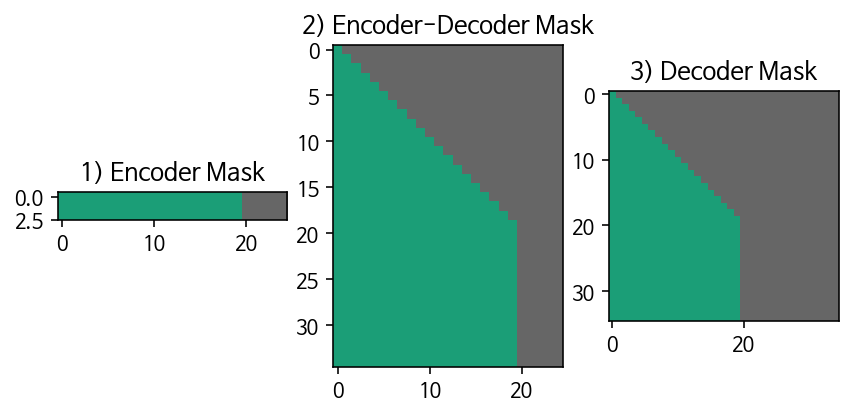

In [28]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데… 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태입니다! 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했던 것을 기억하시죠? 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다!

### LearningRateSchedule 클래스를 상속받아 구현

In [29]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [31]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [32]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [33]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='pre')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [34]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [35]:
import numpy as np
import tensorflow as tf

def generate_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [36]:

sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [37]:

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [38]:
import random
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    print('Translations' )
    for sentence in sentences:
        translate(sentence, transformer, ko_tokenizer, en_tokenizer)
    print()
    print('Hyperparameters' )
    print('n_layers :', n_layers)
    print('d_model :', d_model)
    print('n_heads : ', n_heads)
    print('d_ff :', d_ff)
    print('dropout :', dropout)
    print()
    print('TRAINING')
    print('Warmup Steps: 4000')
    print('Batch size : 64')
    print('Epoch At : ', epoch+1)

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: they was they was a a of they of they of they of they of they of they of they of they of they of they of they of they of they .
Input: 시민들은 도시 속에 산다.
Predicted translation: they was ay of they of they of they of they of they of they of they of they of they of they of they of they of they of they .
Input: 커피는 필요 없다.
Predicted translation: they was they was a of they . s . s . s . s . s . s . s . s . s . s . s . s . s . s . s . s . s . percent . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they was a a a of they of they of they of they of they of they of they of they of they of they of they of they of they of they .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.2

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  1


  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they have been they of they of they of they of they have been killed in the first times of they of they of they of they s around they s .
Input: 커피는 필요 없다.
Predicted translation: they have they don t know they have been they of they of they have been they of they were not been they of they were not been in they of they
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death of the u . s . s . s . m . m . m . m . m . m . m . m . m . m . m . m . m . m . m . m . m . military

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.2

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is a campaign for the first of obama is a campaign is a campaign to be obama is a campaign for the first of the first of the first of the obama is leading to be obama to be obama to be a campaign . .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were they were they of they were they were they in the first in the city of the city s . m . and they were in they were they were they in the city of .
Input: 커피는 필요 없다.
Predicted translation: they don t know they don t know they don t know they don t know they don t think they don t think they don t think they don t think they don t think they .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the plane was killed in southern southern city of the southern city of the southern city s southern city of the southern city s . m . m . m . m . m . m . m . m . much of the city .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.2

TRAINING
Warmup Steps: 4000


  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is a campaigning campaigning campaigning campaigning campaign obama on tuesday on sunday as obama is a obama campaigning obama on sundayself obama on sunday in the obama campaigns of obamas that obama is obama on the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: they ve learned they struck the two city of the two city struck the two mountain s . meters in the city s . ms in the city of the city s office is a small city s office in .
Input: 커피는 필요 없다.
Predicted translation: the coffee don t know the coffee don t know the coffee don t know the coffee don t know the coffee don t know the coffee don t know the coffee won t know the coffee but the coffee won t because they . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: four four four four four people were killed in the four four four people were killed in the four four four four four people were killed in the town of the blasts were killed in the town of the bl

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama on the president of obama on the obama is a presidential campaigning on obama on obama on the president on obama on obama on obama on obama on the presidential nominations obama on the president obama on obama on obama on . .
Input: 시민들은 도시 속에 산다.
Predicted translation: they have been one of the great placed in the great places of the greatest s main place in the city of the city s main city of the city of the city of the greatest city in the city of .
Input: 커피는 필요 없다.
Predicted translation: don t take anything there is no answer for anything in the coffee or no answers are no answers for the tables don t need to be given to be given up for but or but no answers or no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: four four four four four people were killed in the four weeks and the four people were killed and wednesday s death toll on wednesday wednesday s top fire since wednesday s fourth weeks .

Hyperparameters


  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is campaigning for the president who is campaigning for the president who is campaign for the president who is heading the president of the white house to head the president of the white house is heading out of the president of obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they walked in the mountain s streets and the mountain is heading on the mountain s the mountain s greatest in the mountain s peak peak peak in the mountain s main mountain in the beach on the mountain s peak peak beach .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee don t need coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee don t need coffee don t need coffee coffee don t need coffee you can t need you won t need coffee coffee coffee you won t be coffee coffee coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: all of the deadly were killed in wednesday night s deaths and wednesday and wednesday s deaths in 

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the president elected president elect will be obama lead the president elect on february president elected on a former president of the lead to the lead only lead on a figure of the president elect on his president elect to obama . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the mountain is a mountainried as man s great mountain mountain mountain mountain mountain mountain s man is a mountain mountain to be a mountainried in a mountain sl meters of the greatest mountain to be a mountain s great .
Input: 커피는 필요 없다.
Predicted translation: needs to take to take the country to take on the other to take another country in the country to take on the table needs to take the need need to take on the other to need the need to take another country .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine people have died sunday in a crowd since sunday wednesday where a crowd chavez s death toll on sunday wednesday s death toll in a nationalit

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the president ll be in the first time when mccain hours race to be the president ll be a president ll be in the first time when mccain got the president to be president to the president of the president ll be in the first time .
Input: 시민들은 도시 속에 산다.
Predicted translation: they added to the crowds are almost always as far as far as far as med in the battle in which is the battle the mountain struck in which is the righted in the battle in the world s .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee any coffee but needs coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee any coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two nine nine people have died in two battles since friday sunday were killed with two

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama on the white house is a former percentage campaign trail to be obama to the obama of the obama hours to be a number of obama hours obama to be presidential candidates obama to the number to be obama on television of .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man s harbor was place in many s harbor city of many in many city where many city of many in city where a man has a placed in manyahoo s harbor in many people in city .
Input: 커피는 필요 없다.
Predicted translation: need to take place but the north is to take place but if you need to place to take place the north is need to place but need to place to place that important to north korea for the need to put the need to place coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death of the sunday s death was killed sunday after another narrow camp near the death of . another turkish s death was killed in the northern rocky s northern turkish deaths were killed in t

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama said obama gave it should be president
Input: 시민들은 도시 속에 산다.
Predicted translation: it s learned many of many killings it s although places a crowded mante places and two places in places the always s place as many people have been placed in place .
Input: 커피는 필요 없다.
Predicted translation: it needs to take place for the coffee for the coffee for anything that it need only place on which is need on on sunday when you need need to coffee need to coffee for the coffee need to take another coffee . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilian death toll wednesday gave another were killed nearly two people were killed in two neighborhoods on wednesday shooked two people dead were killed and two other people dead were killed in .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.2

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  10


  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama who said he needed to be a member president who the member of the two member of the democratic presidential candidates who needed to be a member of the democratic presidential candidate who virtual during the eighth can thing .
Input: 시민들은 도시 속에 산다.
Predicted translation: it s the crowd comes like many run as many as many as many as many as many as many as many as many as many as there are many as many opportunity .
Input: 커피는 필요 없다.
Predicted translation: need to take her gloves to feel whether there were no needs needed need needs to take pace for questions of the need need need need need important to use important to send for it to rough for no needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death sunday a third earthquake rattled sunday thursday sunday . sunday . sunday . roads in may have killed sunday thursday and four other deaths in the area on tuesday as death toll on tuesday as firefighters tuesday on tuesday

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: he will needs to be the shot in the first president seem delegate but will need to visit the united nations president seems to place the democratic president res presidential visiting presidential candidates should be presidential to delegate .
Input: 시민들은 도시 속에 산다.
Predicted translation: crowds believe crowds the country s place but in huge crowd an place crowded crowds that there are med crowded crowds in huge mountain and waves in italy believe a crowd of mancheing a crowded .
Input: 커피는 필요 없다.
Predicted translation: take coffee for the coffee needs need to take the coffee for the coffee need to take coffee in the coffee for the u . need to take coffee or decst needs to take coffee for the coffee for the dec coffee needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two third director of nine people sunday s seven were killed in sevened in two weeks and nine others have been killed in two weeks since sunday . have been killed

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the presidential presidential candidate will presidential votes mccain member three presidential beak seems beak you to be president lee myung bak from his below the presidential presidential candidates will be president obama to all president .
Input: 시민들은 도시 속에 산다.
Predicted translation: many people in seoul and marked the crowd city of top city man city of man city city city of man city of man city of man city of man city of people are in two thirds of manado city in the city of .
Input: 커피는 필요 없다.
Predicted translation: take on coffee for the coffee for the coffee is been much coffee for the coffee for the coffee for you need coffee and take coffee for your coffee is not coffee for the need to coffee for you need coffee or coffee coffee . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday two others were killed in the deaths last minutes of a voteed in detail sunday sunday thursday and others seven other areas were kill

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: i m proud of the president elect will president elect former president elect president elect barack obama of president elect barack obama being a president elected president elected president elect barack obama of mccain should be president to elect president a step on the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: many of people are thought to places in place by many people are place . billion crowded in crowded crowds in mountain city of four people in place . man city of four people are thought to have be evacuated .
Input: 커피는 필요 없다.
Predicted translation: take caffeine is but you burially whether you take coffee will take place in sales for coffee in coffee in korea december . or deca is whether you will take coffee in december . but you don t take coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine were officials have died in seven other deaths officials since friday s death of sunday were killed near t

  0%|          | 0/402 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: she president seems fuller below of obama in the u . s . presidential visited his presidential visit down almost everybody i president a president who is presidential president so his aide for presidential presidential president .
Input: 시민들은 도시 속에 산다.
Predicted translation: many of two places are in miami where there was two places places in many place where there has two places in the place where there s places in two places and where huge places in their place
Input: 커피는 필요 없다.
Predicted translation: don t need to any care for the u . s . coffee need on penalty . coffee . don t care for any care whether coffee or but you need coffee need any care or that penalty or other penalty any care .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine were officials were injured sunday were reportedly hit with at the deaths and a hospital sunday night at the hospital sunday s streets sunday with at least people in the hospital sunday and o

## 회고

Layer를 2개로 제한했기 때문인지 학습이 제대로 되지 않는 듯한 모습이었습니다. 모델을 단순히 이해하는 것이 아니라 구현한다는 것이 얼마나 어려운일인지 느낄 수 있었습니다.